# Spectrogram classification 모델 구현

## 1. 데이터 처리와 분류

## Wave data 분석

데이터셋은 1초의 오디오 음성 데이터 50,620개로 이루어져 있습니다.

In [3]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)


Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [5]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  5261
Wave data shape :  (8000,)
label :  ['left']


## Label data 처리

구분할 label 목록을 지정하고 text 형태의 데이터를 index로 바꾸어줍니다.

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [7]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

## 학습을 위한 데이터 분리

sklearn에 내장된 train_test_split 함수를 이용해서 train data와 test data를 분리한 후 test_size의 인자를 조절하면 데이터셋의 비율의 조정이 가능합니다.

In [10]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])

del speech_data

print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)


train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


# 2. 학습을 위한 하이퍼파라미터 설정

batch_size는 32로 max_epochs는 10으로 설정하였고 체크포인트 경로를 지정합니다.

## Hyper-parameters setting


In [11]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj31/aiffel/speech_recognition/models/wav'

# 3. 데이터셋 구성

## Data setting


In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label


In [15]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성


## Model

conv1D모델을 사용하였습니다.

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

## Loss


In [19]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])


## Training


In [20]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)


In [21]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )


Train for 1423 steps, validate for 158 steps
Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 1.3685 - accuracy: 0.5490
Epoch 00001: val_loss improved from inf to 1.00421, saving model to /home/aiffel-dj31/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 147s 104ms/step - loss: 1.3683 - accuracy: 0.5491 - val_loss: 1.0042 - val_accuracy: 0.6839
Epoch 2/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.8312 - accuracy: 0.7415
Epoch 00002: val_loss improved from 1.00421 to 0.71863, saving model to /home/aiffel-dj31/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 147s 103ms/step - loss: 0.8310 - accuracy: 0.7416 - val_loss: 0.7186 - val_accuracy: 0.7718
Epoch 3/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.6295 - accuracy: 0.8094
Epoch 00003: val_loss improved from 0.71863 to 0.56650, saving model to /home/aiffel-dj31/aiffel/speech_recognition/models/wav
1423/1423 

# 5. 학습 결과 그래프 출력


## 학습 결과 Plot


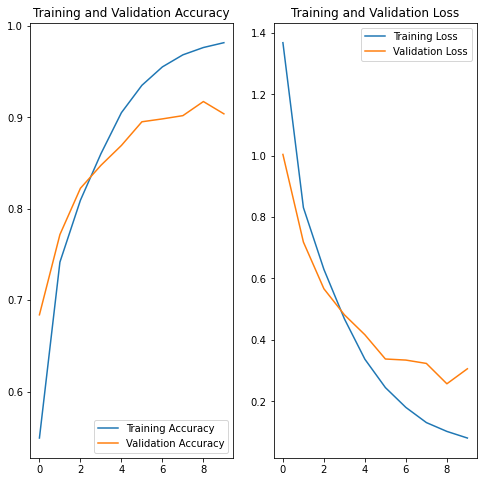

In [33]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


6. Test dataset을 이용해서 모델의 성능을 평가


## Evaluation

93%의 정확도로 꽤 높은 수치를 얻었습니다.

In [36]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 5s 33ms/step - loss: 0.2213 - accuracy: 0.9309
loss value: 0.221
accuracy value: 93.0857%
✅


## Model Test

직접 듣는 과정을 통해 모델이 잘 예측했는지 확인을 할 수가 있습니다.

In [37]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  right


In [45]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')


y_pred: right(Correct!)


## Spectrogram

wav 데이터 안에 얼마나 다양한 주파수가 있는지 Spectogram을 통해 확인할 수 있습니다.

In [42]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D


In [43]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


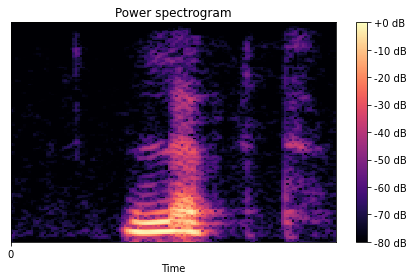

In [44]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

루브릭 평가

1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
변환 후 데이터셋의 구성이 정상적으로 진행됨

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.

스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.

90%이상의 정확도를 달성하였다.

총평

speech_data와 spec_data를 지우지 않아 처음에 애를 많이 먹었다. 노드 가이드에 적혀있는데 꼼꼼히 읽지 탓이 크다는 생각이 들었다. 사소한 것 하나에 시간을 잡아먹는 경우가 많아 노드를 더욱 세세하게 읽자..! 프로젝트를 정리할 때 이미 시간이 많이 소요되어 Conv2d모델을 사용해 보지 못한것이 아쉬웠는데 후에 펀데먼털을 더 진행하고 코드와 전체적인 흐름을 더욱 잘 이해하게 되었을 때 직접 코드를 짜보며 다른 모델을 적용시키면서 프로젝트를 정리할 것이다.